In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/78.2 GB disk)


In [2]:
import os

# Create train and val directories
train_image_dir = './datasets/RHEED/images/train/'
val_image_dir = './datasets/RHEED/images/val/'
train_label_dir = './datasets/RHEED/labels/train/'
val_label_dir = './datasets/RHEED/labels/val/'
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

Bounding Box: center_x=274.749755859375, center_y=170.82164001464844, width=100.62539672851562, height=100.62539672851562
Bounding Box: center_x=242.68789672851562, center_y=462.25787353515625, width=84.61615753173828, height=84.61615753173828
Bounding Box: center_x=335.85791015625, center_y=383.97760009765625, width=141.10018920898438, height=141.10018920898438


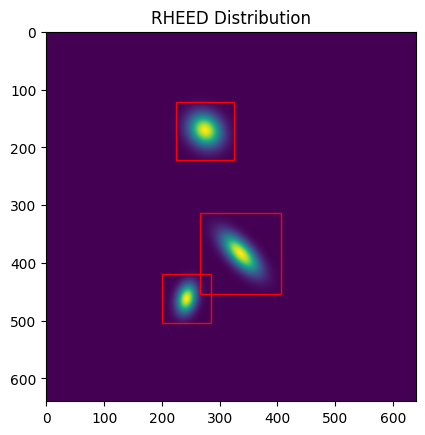

In [3]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

class RheedDataset(Dataset):
    def __init__(self,num_images,  grid_size, size, img_dim=640, testing = False):
        self.size = size
        self.img_dim = img_dim
        self.testing = testing
        self.num_images=num_images
        self.grid_size=grid_size
        self.images = []  # List to store generated images
        self.rheed_grids=[]
        self.bboxes=[]

        for j in range(self.size):
            coordinates = torch.randint(low=0, high=grid_size - img_dim + 1, size=(num_images, 2))

            rheed_grid = np.zeros((self.grid_size, self.grid_size))  # Initialize the RHEED grid
            bboxes = []



            for i in range(self.num_images):
                middle = torch.rand(2) * 400  + 100   # random middle pt

                middle=torch.abs(middle)
                cov = torch.randn(2)/2 * 32 / 2 + 32 / 2 + 1e-3  # random covariance
                cov=torch.abs(cov)
                theta = torch.randn(1) * math.pi +1e-6 # random rotation angle

                x = torch.arange(self.img_dim, dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim)


                y = torch.arange(self.img_dim, dtype=torch.float32).reshape(1, -1).repeat(self.img_dim, 1)


                rota_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                            [torch.sin(theta), torch.cos(theta)]])

                xy = torch.stack([x, y], dim=2)- middle  # shift to mean

                xy = torch.einsum('ijk,kl->ijl', xy, rota_matrix)  # rotation


                img = torch.exp(-0.5 * (xy[:, :, 0]**2 / (cov[0]**2+1e-3) + xy[:, :, 1]**2 / (cov[1]**2+1e-3)))


                img_rgb = torch.cat((img.unsqueeze(0), img.unsqueeze(0), img.unsqueeze(0)), dim=0)  # Convert to RGB, resnet34 takes 3 color channels, our image is grey

                img_rgb = img_rgb / img_rgb.max()
                self.images.append(img_rgb)
                bbox={}
                if cov[1]>cov[0]:
                    bbox = {
                    'center_x': middle[1],
                    'center_y': middle[0],
                    'width': 5 * cov[1], #maybe redo this so that whatever higher covariance is used as both width and height to account for theta(not used in bounding boxes)
                    'height': 5 * cov[1],
                    'theta': theta
                    }
                else:
                    bbox = {
                    'center_x': middle[1],
                    'center_y': middle[0],
                    'width': 5 * cov[0], #maybe redo this so that whatever higher covariance is used as both width and height to account for theta(not used in bounding boxes)
                    'height': 5 * cov[0],
                    'theta': theta
                    }
                x, y = coordinates[i]
                rheed_grid[x:x+self.img_dim, y:y+self.img_dim] = np.add(rheed_grid[x:x+self.img_dim, y:y+self.img_dim], img_rgb[0])  # Add the Gaussian image to the RHEED grid
                bboxes.append(bbox)


            rheed_grid /= np.max(rheed_grid)
            self.bboxes.append(bboxes)
            self.rheed_grids.append(rheed_grid)

    def __len__(self):
        return self.size

    def __getitem__(self,idx):
        return self.rheed_grids[idx],self.bboxes[idx]


# Parameters
num_images = 3
grid_size = 640
img_dim = 640

# Generate RHEED images
dataset = RheedDataset(num_images, grid_size, size=500, img_dim=img_dim)
# print(dataset[0][1])
rheed_images,bboxes = dataset[0]

# Display the RHEED images
fig, ax = plt.subplots()
ax.imshow(rheed_images, cmap='viridis')
ax.set_title('RHEED Distribution')

for bbox in bboxes:
    center_x = bbox['center_x']
    center_y = bbox['center_y']
    width = bbox['width']
    height = bbox['height']
    theta=-math.degrees(bbox['theta'])

    rect = plt.Rectangle((center_x - width/2, center_y - height/2), width, height, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    print(f"Bounding Box: center_x={center_x}, center_y={center_y}, width={width}, height={height}")


plt.savefig('rheed generator')
plt.show()





In [ ]:
train_percentage = 0.8  # Percentage of data to use for training, adjust as needed
num_train = int(len(dataset) * train_percentage)
img_dim=640

for i, (rheed_images, bboxes) in enumerate(dataset):
    # Determine the image path and label path
    image_filename = f'im{i}.jpg'
    label_filename = f'im{i}.txt'
    print(i)
    # Choose the appropriate directory based on train/val split
    if i < num_train:
        image_path = os.path.join(train_image_dir, image_filename)
        label_path = os.path.join(train_label_dir, label_filename)
    elif num_train<=i<int(len(dataset)):
        image_path = os.path.join(val_image_dir, image_filename)
        label_path = os.path.join(val_label_dir, label_filename)
    else:
        break

    # Save the RHEED image
    plt.imsave(image_path, rheed_images, cmap='viridis')

    # Convert the bounding box annotations to YOLO format
    yolo_bboxes = []
    for bbox in bboxes:
        center_x = bbox['center_x']
        center_y = bbox['center_y']
        width = bbox['width']
        height = bbox['height']

        x_center_norm = center_x / img_dim
        y_center_norm = center_y / img_dim
        width_norm = width / img_dim
        height_norm = height / img_dim
        # Append the YOLO-formatted bounding box annotation to the list
        yolo_bbox = f"0 {x_center_norm} {y_center_norm} {width_norm} {height_norm}"
        yolo_bboxes.append(yolo_bbox)

    # Save the YOLO labels to a file
    with open(label_path, 'w') as file:
        file.write('\n'.join(yolo_bboxes))

In [2]:
%cd yolov5
!python train.py --img 640 --epochs 20 --data RHEED.yaml --weights yolov5n.pt --cache

/content/yolov5
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5n.pt, cfg=, data=RHEED.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=1

In [7]:
!python detect.py --weights gaussian20epoch.pt --img 640 --conf 0.25 --source im400.jpg

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['gaussian20epoch.pt'], source=im400.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-193-

In [18]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='gaussian20epoch.pt')

im= 'realrheed.png'


results = model(im)  # inference
crops = results.crop(save=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-18 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
Saved 1 image to runs/detect/exp6
Saved results to runs/detect/exp6

